In [1]:
import os
import scipy.io as sio
from scipy.io import readsav
from scipy.optimize import curve_fit
import numpy as np
from math import *
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib widget
import classStar 
import classPlanet 



Importation des modules de modélisation

In [2]:
from calc_tools import *
from dynamo import *
from magneticmoment import *
from solarwindmodel import *

Constantes de normalisations : Jupiter et le Soleil

In [3]:
MS=1.989e30 #kg
RS=6.96342e8 #m
AS=4.6e9 #yo
BSsw= 1 #T
LS=3.826e26 #W


sol=Star('Sun', MS, RS, AS, BSsw,LS)

MJ=1.8986e27 #kg
#RJ=69911e3   #m
RJ=71492e3
wJ=1.77e-4   #s-1
LJ_norm=1.31e-9
dJ=5.2*149597870700

jup=Planet('Jupiter', MJ, RJ, wJ,wJ,LJ_norm,dJ)


sol.affiche()
jup.affiche()

Name :  Sun
Mass :  1.989e+30  kg
Radius :  696342000.0  m
Age :  4600000000.0  y
SW magnetic field :  1 T
Luminosity :  3.826e+26 W
Name :  Jupiter
Mass :  1.8986e+27  kg
Radius :  71492000.0  m
Rotation rate :  0.000177  s-1
Orbital period :  0.000177 s-1
Luminosity :  1.31e-09 W
Distance to host star :  777908927640.0 m


Fichier de configuration

In [4]:
config=pd.read_csv(r"/Users/emauduit/Documents/Thèse/Sélection des cibles/Programmes/parametres.csv", delimiter=';')

Fichier de données

In [5]:
targets=pd.read_csv(r"/Users/emauduit/Documents/Thèse/Sélection des cibles/Programmes/exoplanet.eu_catalog.csv", delimiter=',')

In [6]:
config.info()
targets.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Setting  7 non-null      object
 1   Value    7 non-null      int64 
dtypes: int64(1), object(1)
memory usage: 240.0+ bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4929 entries, 0 to 4928
Data columns (total 98 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   # name                      4929 non-null   object 
 1   planet_status               4929 non-null   object 
 2   mass                        1563 non-null   float64
 3   mass_error_min              1443 non-null   float64
 4   mass_error_max              1430 non-null   float64
 5   mass_sini                   1097 non-null   float64
 6   mass_sini_error_min         943 non-null    float64
 7   mass_sini_error_max         942 non-null    float64
 8   radius         

Tests with a short list of planets in order to compare with the results in JMG thesis.

In [7]:
test_targets=pd.DataFrame({'star_radius' : [1.0,1.0,1.18,1.12,1.48,1.48,1.48], 'star_mass':[1.0,1.0,1.06,1.1,1.42,1.42,1.42],'star_age' : [4.6,4.6,5.5,3.0,1.0,1.0,1.0], 'planet_radius':[1.0,0.84,1.42,1.25,1.2,1.58,1.48], 'planet_mass':[1.0,0.3, 0.69,1.18,4.4,7.0,10.0], 'planet_orbital_frequency':[1.0,0.93,0.12,0.34,0.12,0.12,0.12], 'planet_distance':[5.2,9.5,0.045,0.0225,0.0489,0.0489,0.0489]}, index=['Jupiter','Saturn','HD 209458b','OGLE-TR-56b','T-bootes (light)','T-bootes (medium)','T-bootes (heavy)'])
#print(test_targets)
#print(test_targets.loc['Jupiter'])

rc1=[]
rc2=[]
rhoc1=[]
rhoc2=[]

rc1_norm=[]
rc2_norm=[]

for x in test_targets.itertuples():
    pla=Planet(x.Index,x.planet_mass, x.planet_radius, x.planet_orbital_frequency,1,1, x.planet_distance)
    r1=LaneEmden(pla.mass*jup.mass, pla.radius*jup.radius,1000)
    r2=LaneEmden(pla.mass*jup.mass, pla.radius*jup.radius,700)
    rc1.append(r1)
    rc2.append(r2)
    rc1_norm.append(r1/(pla.radius*jup.radius))
    rc2_norm.append(r2/(pla.radius*jup.radius))

    rho1=rhodyn(pla.mass*jup.mass,pla.radius*jup.radius,r1)
    rho2=rhodyn(pla.mass*jup.mass,pla.radius*jup.radius,r2)
    rhoc1.append(rho1)
    rhoc2.append(rho2)

rc1_normJ=np.array(rc1)/rc1[0]
rc2_normJ=np.array(rc2)/rc2[0]
rhoc1_norm=np.array(rhoc1)/rhoc1[0]
rhoc2_norm=np.array(rhoc2)/rhoc2[0]

test_results_dynamo=pd.DataFrame({'rc1':rc1_norm, 'rc2':rc2_norm, 'rhoc1':rhoc1_norm, 'rhoc2':rhoc2_norm}, index=['Jupiter','Saturn','HD 209458b','OGLE-TR-56b','T-bootes (light)','T-bootes (medium)','T-bootes (heavy)'] )


print(test_results_dynamo)


                        rc1       rc2     rhoc1     rhoc2
Jupiter            0.791454  0.848782  1.000000  1.000000
Saturn             0.615022  0.721287  0.676447  0.647143
HD 209458b         0.000000  0.438998  0.000000  0.442728
OGLE-TR-56b        0.672431  0.762088  0.742792  0.718751
T-bootes (light)   0.911164  0.936492  1.957362  2.065509
T-bootes (medium)  0.875936  0.910804  1.483899  1.536665
T-bootes (heavy)   0.000000  0.947091  0.000000  2.433248


Calculations and plots of rho, rho' and Rc for a given planet.

0.9364921580425362
2.0655085458566993


/Users/emauduit/Documents/GitHub/Target_selection/dynamo.py:25: RuntimeWarning: invalid value encountered in double_scalars
  res=a*np.sin(b)/b
/Users/emauduit/Documents/GitHub/Target_selection/dynamo.py:30: RuntimeWarning: divide by zero encountered in double_scalars
  res=a*((np.cos(np.pi*r/Rp)/r)-(np.sin(np.pi*r/Rp)*Rp/(np.pi*pow(r,2))))
/Users/emauduit/Documents/GitHub/Target_selection/dynamo.py:30: RuntimeWarning: invalid value encountered in double_scalars
  res=a*((np.cos(np.pi*r/Rp)/r)-(np.sin(np.pi*r/Rp)*Rp/(np.pi*pow(r,2))))


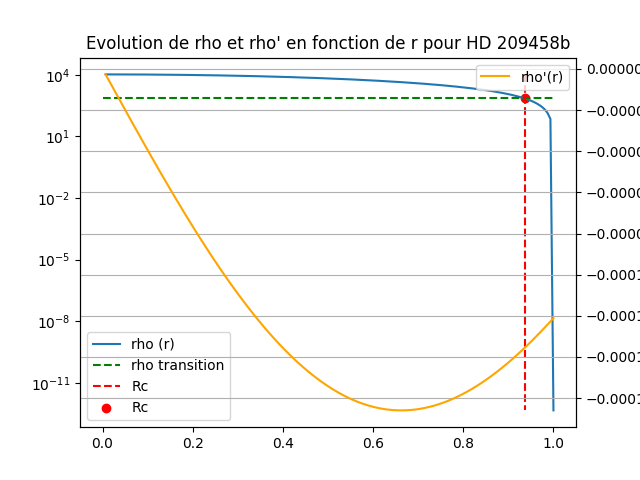

In [8]:
R=np.linspace(0.0,1.2,150)*jup.radius
Mp=4.4*jup.mass
Rp=1.2*jup.radius
rho=[]
rhop=[]
rhott=700

a=-np.pi*Mp/(4*pow(Rp,4))
rcJ=LaneEmden(MJ,RJ,rhott)
rctt=LaneEmden(Mp,Rp,rhott)
rhoctt=rhodyn(Mp,Rp,rctt)

rhocJ=rhodyn(MJ,RJ,rcJ)
print(rctt/Rp)
print(rhoctt/rhocJ)
for i in range(len(R)):
    rho.append(rhoLE(R[i],Mp,Rp,rhott)+rhott)
    rhop.append(rhoLEp(R[i],Mp,Rp,rhott))

plt.figure()
plt.plot(R/Rp,rho, label='rho (r)')
plt.plot(R/Rp,np.full(150,rhott), 'g--', label='rho transition')
plt.plot(np.full(150,rctt/Rp),rho, 'r--', label='Rc')
plt.scatter(rctt/Rp,rhott,color='red', label='Rc')
plt.yscale('log')
plt.legend()
plt.twinx()
plt.plot(R/Rp,rhop, color='orange',label="rho'(r)")
#plt.scatter(Rp,a,marker='x',color='green')
plt.xlabel('Rayon en m')
plt.title("Evolution de rho et rho' en fonction de r pour HD 209458b")
plt.legend()
plt.grid()
plt.show()

Test for luminosity computing with tables from Burrows, 1997, data retreived in logarithmic scale converted into linear scale.

In [9]:
table_1MJ=pd.read_csv(r'/Users/emauduit/Documents/Thèse/Sélection des cibles/Programmes/1MJ.csv', delimiter=';')
table_5MJ=pd.read_csv(r'/Users/emauduit/Documents/Thèse/Sélection des cibles/Programmes/5MJ.csv', delimiter=';')
table_10MJ=pd.read_csv(r'/Users/emauduit/Documents/Thèse/Sélection des cibles/Programmes/10MJ.csv', delimiter=';')

table_10MJ.info()
#t=np.array(10**table_10MJ['log(t) (Gyr)'])
#L=np.array(10**table_10MJ['log(L/Ls)'])
#R=np.array(table_10MJ['R(10^9 cm)']*1e7)

#table_10MJ_lin=pd.DataFrame({'t_Gyr' : t, 'L_Ls' : L, 'R_m' : R})

#table_10MJ_lin.to_csv('10MJ.csv', sep=';')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  20 non-null     int64  
 1   t_Gyr       20 non-null     float64
 2   L_Ls        20 non-null     float64
 3   R_m         20 non-null     float64
dtypes: float64(3), int64(1)
memory usage: 768.0 bytes


Curvefit of L/Ls(t) and R(t), to better estimate the value of L. --> not working

In [10]:
def fit_luminosity(x,a,b):
    return(a*np.power(x,b))

popt1, pcov1 = curve_fit(fit_luminosity,table_1MJ['t_Gyr'], table_1MJ['L_Ls'],p0=[95,-1.12])
popt5, pcov5 = curve_fit(fit_luminosity,table_5MJ['t_Gyr'], table_5MJ['L_Ls'],p0=[5200,-1.19])
popt10, pcov10 = curve_fit(fit_luminosity,table_10MJ['t_Gyr'], table_10MJ['L_Ls'],p0=[34500,-1.2])

print(popt1)
print(pcov1)

[ 1.56579856e-08 -9.88726548e-01]
[[5.37442862e-19 5.18632637e-12]
 [5.18632637e-12 5.03233776e-05]]


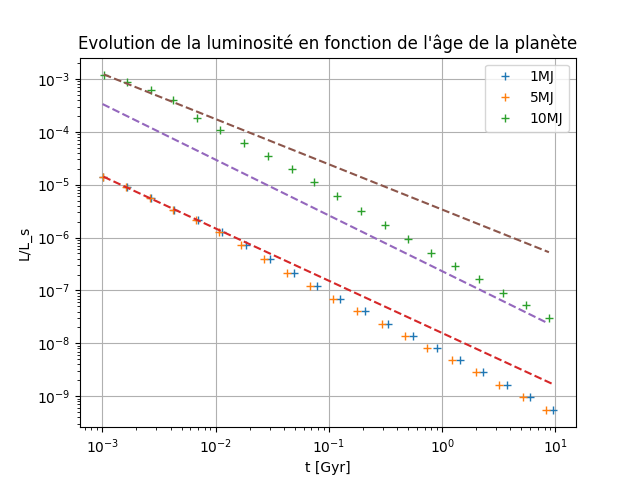

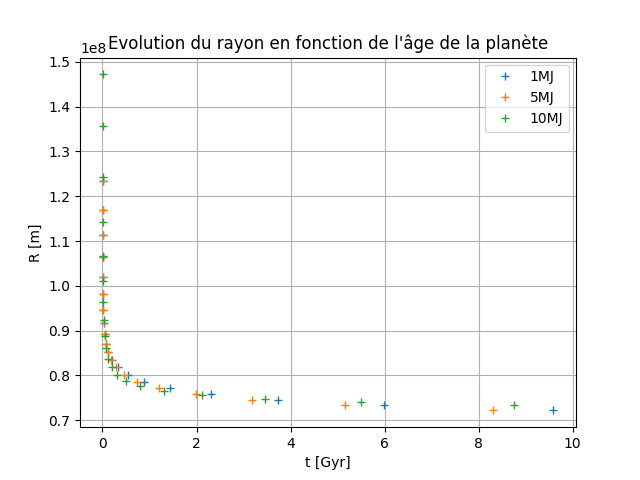

In [11]:
plt.figure()
plt.plot(table_1MJ['t_Gyr'],table_1MJ['L_Ls'],'+', label='1MJ')
plt.plot(table_5MJ['t_Gyr'],table_1MJ['L_Ls'], '+', label='5MJ')
plt.plot(table_10MJ['t_Gyr'],table_10MJ['L_Ls'], '+', label='10MJ')
plt.plot(table_1MJ['t_Gyr'],fit_luminosity(table_1MJ['t_Gyr'],*popt1),'--')
plt.plot(table_5MJ['t_Gyr'],fit_luminosity(table_5MJ['t_Gyr'],*popt5),'--')
plt.plot(table_10MJ['t_Gyr'],fit_luminosity(table_10MJ['t_Gyr'],*popt10),'--')
plt.xlabel('t [Gyr]')
plt.ylabel('L/L_s')
plt.xscale('log')
plt.yscale('log')
plt.title("Evolution de la luminosité en fonction de l'âge de la planète")
plt.grid()
plt.legend()
plt.show()

plt.figure()
plt.plot(table_1MJ['t_Gyr'],table_1MJ['R_m'],'+', label='1MJ')
plt.plot(table_5MJ['t_Gyr'],table_1MJ['R_m'],'+', label='5MJ')
plt.plot(table_10MJ['t_Gyr'],table_10MJ['R_m'],'+', label='10MJ')
plt.xlabel('t [Gyr]')
plt.ylabel('R [m]')
#plt.xscale('log')
#plt.yscale('log')
plt.title("Evolution du rayon en fonction de l'âge de la planète")
plt.grid()
plt.legend()
plt.show()


In [12]:
LJ_norm=jup.calculate_luminosity(sol.age,table_1MJ,table_5MJ, table_10MJ)
jup.affiche()

Name :  Jupiter
Mass :  1.8986e+27  kg
Radius :  71492000.0  m
Rotation rate :  0.000177  s-1
Orbital period :  0.000177 s-1
Luminosity :  5.395106225151267e-10 W
Distance to host star :  777908927640.0 m


Test plot of B(t) from Reiners&Christensen's paper

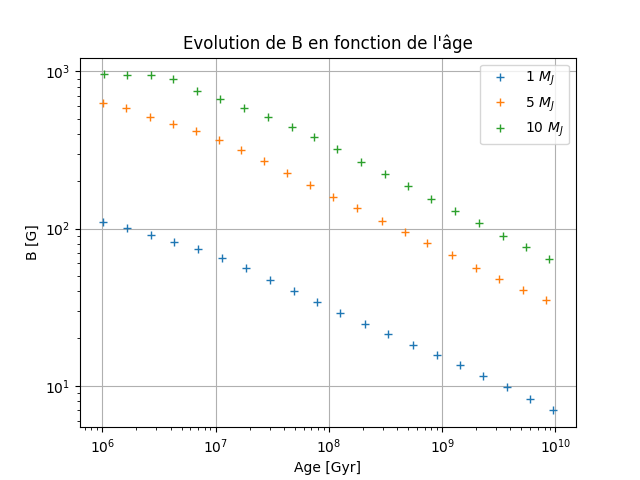

In [13]:
B_1=[]

for i in range(20):
    L=table_1MJ['L_Ls'][i]
    R=table_1MJ['R_m'][i]/sol.radius
    Mp=1*jup.mass/sol.mass
    a=Mp*pow(L,2)*pow(R,-7)
    b=pow(1-(0.17/(1.0)),3)
    res=4.8*b*pow(a,1/6)/(2*np.sqrt(2))
    B_1.append(2*res*1e3)

B_5=[]

for i in range(20):
    L=table_5MJ['L_Ls'][i]
    R=table_5MJ['R_m'][i]/sol.radius
    Mp=5*jup.mass/sol.mass
    a=Mp*(L**2)*pow(R,-7)
    b=pow(1-(0.17/(5.0)),3)
    res=4.8*b*pow(a,1/6)/(2*sqrt(2))
    B_5.append(2*res*1e3)

B_10=[]

for i in range(20):
    L=table_10MJ['L_Ls'][i]
    R=table_10MJ['R_m'][i]/sol.radius
    Mp=10*jup.mass/sol.mass
    a=Mp*(L**2)*pow(R,-7)
    b=pow(1-(0.17/(10.0)),3)
    res=4.8*b*pow(a,1/6)/(2*sqrt(2))
    B_10.append(2*res*1e3)

plt.figure()
plt.plot(table_1MJ['t_Gyr']*1e9,B_1,'+', label='1 $M_J$')
plt.plot(table_5MJ['t_Gyr']*1e9,B_5,'+', label='5 $M_J$')
plt.plot(table_10MJ['t_Gyr']*1e9,B_10,'+', label='10 $M_J$')
plt.xlabel('Age [Gyr]')
plt.ylabel('B [G]')
plt.title("Evolution de B en fonction de l'âge")
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.legend()

We add this table of luminosities in the model of Reiners&Christensen for the estimation of the dipolar magnetic moment.
The table gives values of L and Rp with respect to the age of the planet. 

Suggestion/idea : we can estimate the age of the planet by saying it is t*-0,5 en Gyr ? --> we then retreive the value of R and L associated. If we know the radius of the planet, we simply take the value of L associated to the closest value of Rp in the table.

Nota : For the two model of Mizutani we suppose that the electric conductivity in the dynamo region is the same as Jupiter, so normalized to Jupiter this value is 1.

In [14]:
M_sano1=[]
M_sano2=[]
M_Busse1=[]
M_Busse2=[]
M_MizuM1=[]
M_MizuM2=[]
M_MizuS1=[]
M_MizuS2=[]
M_RC=[]


i=0
for x in test_targets.itertuples():
    r1=rc1_normJ[i]
    r2=rc2_normJ[i]
    rho1=rhoc1_norm[i]
    rho2=rhoc2_norm[i]
    
    star=Star('Name', x.star_mass, x.star_radius, x.star_age,1,1)
    pla=Planet(x.Index,x.planet_mass, x.planet_radius,x.planet_orbital_frequency,x.planet_orbital_frequency,1,x.planet_distance)
    
    M_sano1.append(sano(r1,pla.rotrate,rho1))
    M_sano2.append(sano(r2,pla.rotrate,rho2))
    M_Busse1.append(Busse(r1,pla.rotrate,rho1))
    M_Busse2.append(Busse(r2,pla.rotrate,rho2))
    M_MizuM1.append(Mizu_moderate(r1,pla.rotrate,rho1,1.0))
    M_MizuM2.append(Mizu_moderate(r2,pla.rotrate,rho2,1.0))
    M_MizuS1.append(Mizu_slow(r1,pla.rotrate,rho1,1.0))
    M_MizuS2.append(Mizu_slow(r2,pla.rotrate,rho2,1.0))

    M_RC.append(Reiners_Christensen(pla,star, jup,sol,table_1MJ,table_5MJ,table_10MJ))
    i+=1

M_sano1_norm=np.array(M_sano1)/M_sano1[0]
M_sano2_norm=np.array(M_sano2)/M_sano2[0]
M_RC_norm=np.array(M_RC)/M_RC[0]

test_results_moments=pd.DataFrame({'M_sano1': M_sano1, 'M_sano2' : M_sano2, 'M_RC' : M_RC, 'M_Busse1': M_Busse1, 'M_Busse2':M_Busse2, 'M_MizuM1':M_MizuM1, 'M_MizuM2':M_MizuM2, 'M_MizuS1':M_MizuS1,'M_MizuS2':M_MizuS2},index=['Jupiter','Saturn','HD 209458b','OGLE-TR-56b','T-bootes (light)','T-bootes (medium)','T-bootes (heavy)'])

    
#print(test_results_dynamo)
print(test_results_moments) 


                    M_sano1   M_sano2       M_RC  M_Busse1  M_Busse2  \
Jupiter            1.000000  1.000000   1.450998  1.000000  1.000000   
Saturn             0.171872  0.229907   0.122724  0.138860  0.194244   
HD 209458b         0.000000  0.027108   1.618945  0.000000  0.023231   
OGLE-TR-56b        0.361721  0.431702   2.965281  0.372769  0.457345   
T-bootes (light)   0.520294  0.460582   6.910400  0.611540  0.529971   
T-bootes (medium)  1.033584  0.944000  12.925719  1.366777  1.229178   
T-bootes (heavy)   0.000000  1.083367  12.442455  0.000000  1.392209   

                   M_MizuM1  M_MizuM2  M_MizuS1  M_MizuS2  
Jupiter            1.000000  1.000000  1.000000  1.000000  
Saturn             0.175019  0.234116  0.220593  0.282173  
HD 209458b         0.000000  0.046057  0.000000  0.091311  
OGLE-TR-56b        0.473701  0.565346  0.601961  0.698852  
T-bootes (light)   0.884003  0.782550  1.277857  1.155505  
T-bootes (medium)  1.756105  1.603897  2.256334  2.092851  
T-b

Taking tidal locking into account : we compute the orbital period of the planet, if necessary, we read the targets file. If for the current target the rotation rate is not defined, we compute it by taking into accout the tidal locking effect. 



In [15]:
M_sano1=[]
M_sano2=[]
M_Busse1=[]
M_Busse2=[]
M_MizuM1=[]
M_MizuM2=[]
M_MizuS1=[]
M_MizuS2=[]
M_RC=[]


i=0
for x in test_targets.itertuples():
    r1=rc1_normJ[i]
    r2=rc2_normJ[i]
    rho1=rhoc1_norm[i]
    rho2=rhoc2_norm[i]
    
    star=Star('Name', x.star_mass, x.star_radius, x.star_age,1,1)
    pla=Planet(x.Index,x.planet_mass, x.planet_radius,x.planet_orbital_frequency, x.planet_orbital_frequency,1,x.planet_distance)
    pla.tidal_locking(star.age,star.mass)
    print(pla.rotrate, pla.orbitperiod)

    M_sano1.append(sano(r1,pla.rotrate,rho1))
    M_sano2.append(sano(r2,pla.rotrate,rho2))
    M_Busse1.append(Busse(r1,pla.rotrate,rho1))
    M_Busse2.append(Busse(r2,pla.rotrate,rho2))
    M_MizuM1.append(Mizu_moderate(r1,pla.rotrate,rho1,1.0))
    M_MizuM2.append(Mizu_moderate(r2,pla.rotrate,rho2,1.0))
    M_MizuS1.append(Mizu_slow(r1,pla.rotrate,rho1,1.0))
    M_MizuS2.append(Mizu_slow(r2,pla.rotrate,rho2,1.0))

    M_RC.append(Reiners_Christensen(pla,star, jup,sol,table_1MJ,table_5MJ,table_10MJ))
    i+=1

M_sano1_norm=np.array(M_sano1)/M_sano1[0]
M_sano2_norm=np.array(M_sano2)/M_sano2[0]
M_RC_norm=np.array(M_RC)/M_RC[0]

test_results_moments_TL=pd.DataFrame({'M_sano1': M_sano1, 'M_sano2' : M_sano2, 'M_RC' : M_RC, 'M_Busse1': M_Busse1, 'M_Busse2':M_Busse2, 'M_MizuM1':M_MizuM1, 'M_MizuM2':M_MizuM2, 'M_MizuS1':M_MizuS1,'M_MizuS2':M_MizuS2},index=['Jupiter','Saturn','HD 209458b','OGLE-TR-56b','T-bootes (light)','T-bootes (medium)','T-bootes (heavy)'])

    
#print(test_results_dynamo)
print(test_results_moments_TL)    

1.0 1.0
1.0 0.93
0.12 0.12
0.34 0.34
0.12 0.12
0.12 0.12
0.12 0.12
                    M_sano1   M_sano2       M_RC  M_Busse1  M_Busse2  \
Jupiter            1.000000  1.000000   1.450998  1.000000  1.000000   
Saturn             0.184809  0.247212   0.122724  0.149312  0.208865   
HD 209458b         0.000000  0.027108   1.618945  0.000000  0.023231   
OGLE-TR-56b        0.361721  0.431702   2.965281  0.372769  0.457345   
T-bootes (light)   0.520294  0.460582   6.910400  0.611540  0.529971   
T-bootes (medium)  1.033584  0.944000  12.925719  1.366777  1.229178   
T-bootes (heavy)   0.000000  1.083367  12.442455  0.000000  1.392209   

                   M_MizuM1  M_MizuM2  M_MizuS1  M_MizuS2  
Jupiter            1.000000  1.000000  1.000000  1.000000  
Saturn             0.184809  0.247212  0.228744  0.292600  
HD 209458b         0.000000  0.046057  0.000000  0.091311  
OGLE-TR-56b        0.473701  0.565346  0.601961  0.698852  
T-bootes (light)   0.884003  0.782550  1.277857  1.15550

Plot of magnetic moments values computed with (+) and without (x) taking the tidal locking into account. If planets are tidally locked, their rotation rate is taken equal to their orbital period, and if not it is taken equal to Jupiter's rotation rate.

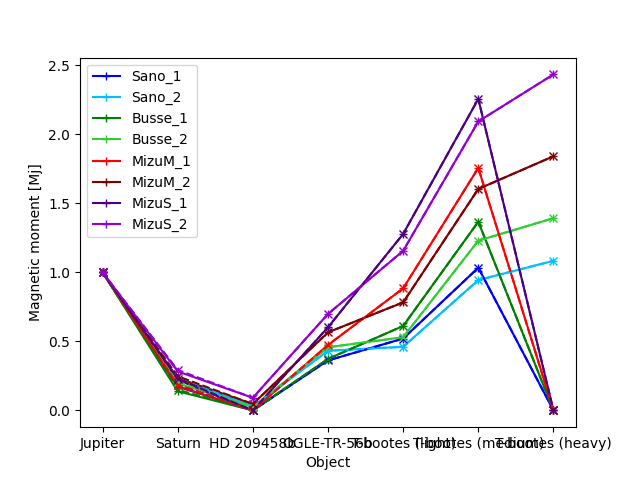

In [17]:
fig, ax = plt.subplots()
xs=range(7)
labels = test_results_moments.index
def format_fn(tick_val, tick_pos):
    if int(tick_val) in xs:
        return labels[int(tick_val)]
    else:
        return ''

ax.xaxis.set_major_formatter(format_fn)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(xs,test_results_moments['M_sano1'], '+-', color='blue', label='Sano_1')
ax.plot(xs,test_results_moments['M_sano2'], '+-', color='deepskyblue', label='Sano_2')
ax.plot(xs,test_results_moments['M_Busse1'], '+-', color='green', label='Busse_1')
ax.plot(xs,test_results_moments['M_Busse2'], '+-', color='limegreen', label='Busse_2')
ax.plot(xs,test_results_moments['M_MizuM1'], '+-', color='red', label='MizuM_1')
ax.plot(xs,test_results_moments['M_MizuM2'], '+-', color='maroon', label='MizuM_2')
ax.plot(xs,test_results_moments['M_MizuS1'], '+-', color='indigo', label='MizuS_1')
ax.plot(xs,test_results_moments['M_MizuS2'], '+-', color='darkviolet', label='MizuS_2')
plt.legend()
ax.plot(xs,test_results_moments_TL['M_sano1'], 'x--', color='blue', label='Sano_1')
ax.plot(xs,test_results_moments_TL['M_sano2'], 'x--', color='deepskyblue', label='Sano_2')
ax.plot(xs,test_results_moments_TL['M_Busse1'], 'x--', color='green', label='Busse_1')
ax.plot(xs,test_results_moments_TL['M_Busse2'], 'x--', color='limegreen', label='Busse_2')
ax.plot(xs,test_results_moments_TL['M_MizuM1'], 'x--', color='red', label='MizuM_1')
ax.plot(xs,test_results_moments_TL['M_MizuM2'], 'x--', color='maroon', label='MizuM_2')
ax.plot(xs,test_results_moments_TL['M_MizuS1'], 'x--', color='indigo', label='MizuS_1')
ax.plot(xs,test_results_moments_TL['M_MizuS2'], 'x--', color='darkviolet', label='MizuS_2')
plt.xlabel('Object')
plt.ylabel('Magnetic moment [Mj]')
plt.show()